# Inverse problems in Geosciences  
Geosciences as a field are a prime example for inverse problems. A lot of problems in geosciences are ill-posed, fundamentally due to the lack of observation data. As direct observations in the subsurface are limited to trenches, pits (not really deep) and boreholes (one dimensional), the majority of the subsurface has to be explored via indirect methods.  
However, also data from indirect observation methods do not solve a fundamental problem in geosciences:  
<center>*Although being totally deterministic, uncertainty remains as we cannot observe the whole system.*</center>  
The deepest direct observation we have is the [Kola Superdeep Borehole](https://en.wikipedia.org/wiki/Kola_Superdeep_Borehole) with a final depth of 12,262 metres below the ground level. While still the deepest borehole, it is not the longest borehole worldwide anymore, as progress in (sub-)horizontal drilling technique facilitated the construction in long horizontal boreholes.  

However, having drilled 12 km in the Earth means that we penetrated 0.19 % of the Earth's radius, i.e. the distance to the center. To put that into perspective, if Earth was an average apple (with a diameter of 70 mm), we would not even have drilled through its skin (which has an average thickness of 0.3 mm)!  

So how do scientists know the internal structure of the Earth? By using indirect observation techniques, in this case waves triggered by Earthquakes (let's call them EQ-waves). In this field of science called seismology, the location of an Earthquake is important to know. However, seismographs (the measuring devices) only register the magnitude, direction and time of arriving EQ-waves. For estimating the location of the origin of the earthquake, the __hypocenter__ (whose lateral position projected to the Earth's surface is called __epicenter__) we need to solve an __inverse problem__.



## Contents  
1. [Problem definition](#prob_def)  
2. [Equations](#eqs)    
3. [Data](#data)

<a id='prob_def'></a>   
### Problem definition  

In this notebook, we go through the process of locating a epicenter of an earthquake by using the least squares method. This is a very basic optimization, i.e. fitting algorithm (fitting a line to a bunch of observation points is an inverse process itself). The following data can code are from the course "_Inverse problems_" I heard at the Rennes 1 University in Brittany, France.  


<a id='eqs'></a> 
### Equations


Arrival time (so one of the given variables) is a function of time (t) and space (x, y, z)


$$F_i(m) = t_{obs} = t_0 + \frac{1}{v_p} \times [(x_i - x_0)^2 + (y_i - y_0)^2 + z_0^2]^{0.5} $$  

where  
* F$_i(m)$, t$_{obs}$ is the measured arrival times [s]  
* t$_0$ is the origin time [s]  
* v$_p$ is the p-wave velocity [m s$^{-1}$]  
* (x$_i$, y$_i$) are the coordinates of the seismic stations at z$_i = 0$ (i.e. ground surface)  
* (x$_0$, y$_0$, z$_0$) are the spatial coordinates of the Earthquake.  

Generally, the problem can be defined as  

$$d_i = A(m_j)$$  
* i = 1, 2, ..., N (number of data)  
* j = 1, 2, ..., M (number of model parameters)

Which means, a suited model $A$ with the correct parameters $m_j$ is able to _reproduce_ observations $d_i$ by using the model (so simulating data, let's call that $d_{si}$. For yielding the best parameters, one minimizes the misfit $\Delta d_i = d_{si} - d_i$.  

Often, simulated responses ($d_{si}$) does not respond linearly to changes in model parameters. A solution to this problem is linearizing it (e.g. by Taylor series expansion).  
$$ \vec{d}_{i} = G_{ij} \vec{m}_{j} $$  

where $ \vec{d}_{i}$ is the misfit between simulated data and observations ($d_{si} - d_i$), $G_{ij}$ is matrix with partial derivatives of every model parameter with respect to the observations, i.e. the correlation matrix. $\vec{m}_{j} $ is the gradient vector of the model parameters. So, $G_{ij}$ has as many rows as observations (_here number of stations_), and as many columns as parameters (_here 4: x, y, z, t_). One row of $G_{ij}$ with respect to the equation $F_i(m)$ above would be:  

$$ \bigg[\frac{\partial F(m)}{\partial t} \quad \frac{\partial F(m)}{\partial x} \quad  \frac{\partial F(m)}{\partial y} \quad \frac{\partial F(m)}{\partial z} \bigg] $$  

We iteratively calculate the correlation matrix ($G_{ij}$) and the data misfit ($\vec{d}_i$, or from one iteration to another $\Delta d$) , starting from an initial guess of the hypocenter. We can then calculate the gradient $\vec{m}_j$ (from one iteration to another $\Delta m$). 

$$\Delta m = (G^T G)^{-1} G^T \Delta d $$  

This gradient is used to calculate model parameters for the next iteration (_iter_)    

$$ m_{iter} = m_{iter-1} + \Delta m $$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
%matplotlib inline

<a id='data'></a>  
### Data  

Using arrival times at different stations, we will estimate the origin time and hypocenter of an earthquake in Switzerland. Provided data comprises Longitude, Latitude, Altitude (in km), and relative arrival times of the p-waves (v$_p$) (in s). So, we have a model with four variables (x, y, z, t) which are recorded by 25 stations. That essentially means that (assuming a constant v$_p$), we have an over determined problem.

In [7]:
# let's load the data
border = np.genfromtxt('border.xy')
dat = p.read_csv('loctim.txt',delim_whitespace=True)
dat.head()

,longitude,latitude,altitude,vp_arrival_t
0,7.2313,47.395,0.86,45.969
1,8.2428,46.950,0.88,50.980
2,6.9614,46.775,0.72,52.146
3,8.3894,47.482,0.78,52.188
4,8.1511,46.757,1.28,52.260


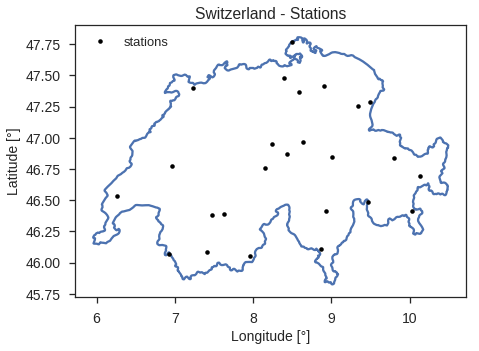

In [18]:
# plot the map of Switzerland together with the stations
fig = plt.figure(figsize=[7,5])
plt.plot(border[:,0],border[:,1])
plt.plot(dat.longitude, dat.latitude, 'k.', label='stations')
plt.xlabel('Longitude [°]', fontsize=14)
plt.ylabel('Latitude [°]', fontsize=14)
plt.title('Switzerland - Stations')
plt.tick_params(axis='both', labelsize=14)
plt.legend(loc=2)

In [4]:
v = 5.5  
lonkm = 75.82  
latkm = 111.19  
z0 = 10  
ert = 0.05  
erc = ert*v  
sig = np.array([ert,erc,erc])
vsig = np.var(sig)

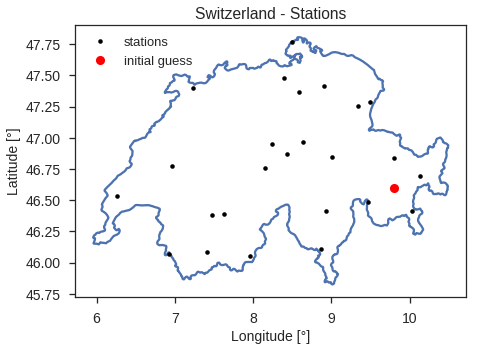

In [16]:
# initial guess  
lon0 = 9.8  
lat0 = 46.6  

fig = plt.figure(figsize=[7, 5])
plt.plot(border[:,0],border[:,1])
plt.plot(dat.longitude, dat.latitude, 'k.', label='stations')
plt.plot(lon0,lat0,'ro', label='initial guess')
plt.xlabel('Longitude [°]', fontsize=14)
plt.ylabel('Latitude [°]', fontsize=14)
plt.title('Switzerland - Stations')
plt.tick_params(axis='both', labelsize=14)
plt.legend(loc=2)

In [15]:
t0 = np.sqrt((lonkm*(lon0 - dat.longitude[1]))**2 + (latkm*(lat0 - dat.latitude[1]))**2 + 
            (z0 - dat.altitude[1])**2)/v

In [16]:
m = np.array([t0,lon0,lat0])